# Introduction: Random Forest in Python

In this notebook, we will implement a random forest in Python. With machine learning in Python, it's very easy to build a complex model without having any idea how it works. Therefore, we'll start with a single decision tree and a simple problem, and then work our way to a random forest and a real-world problem. 

Once we understand how a single decision tree thinks, we can transfer this knowledge to an entire forest of trees.

In [1]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 50

# Start Simple: Basic Problem

To begin, we'll use a very simple problems with only two features and two classes. This is a binary classification problem. 

First, we create the features `X` and the labels `y`. There are only two features, which will allow us to visualize the data and which makes this a very easy problem. 

In [2]:
X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3]])

y = np.array([0, 1, 1, 1, 0, 1])

### Data Visualization

To get a sense of the data, we can graph the data points with the number showing the label. 

Text(0.5, 1.0, 'Data')

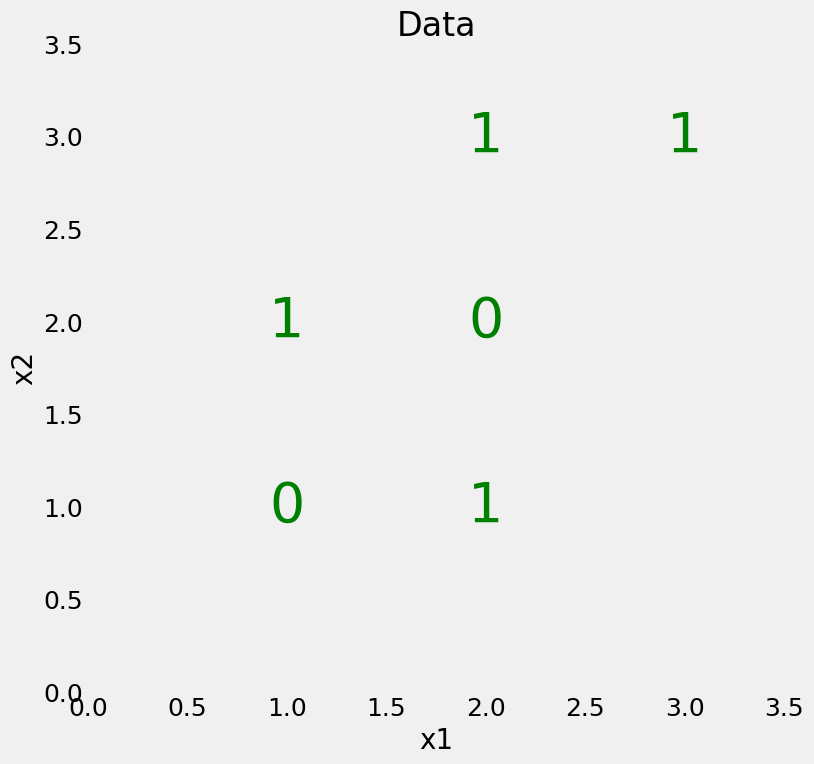

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

Even though there are only two features, this is a linearly inseparable problem. A simple linear classifier will not be able to draw a boundary that separates the classes. The single decision tree will be able to completely separate the points because it essentially draws many repeated linear boundaries between points. A decision tree is a non-parametric model because the number of parameters grows with the size of the data.

## Single Decision Tree

Here we quickly build and train a single decision tree on the data using Scikit-Learn. The tree will learn how to separate the points, building a flowchart of questions based on the feature values and the labels. At each stage, the decision tree makes splits by maximizing the reduction in Gini impurity. 

We'll use the default hyperparameters for the decision tree which means it can grow as deep as necessary in order to completely separate the classes. This will lead to overfitting because the model memorizes the training data, and in practice, we usually want to limit the depth of the tree so it can generalize to testing data.

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X, y)

DecisionTreeClassifier(random_state=50)

In [5]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 9 nodes with maximum depth 3.


Our decision tree formed 9 nodes and reached a maximum depth of 3. It will have achieved 100% accuracy on the training data because we did not limit the depth and it therefore can classify every _training_ point perfectly.

In [6]:
print(f'Model Accuracy: {tree.score(X, y)}')

Model Accuracy: 1.0


## Visualize Decision Tree

To get a sense of how the decision tree "thinks", it's helpful to visualize the entire structure. This will show each node in the tree which we can use to make new predictions. Because the tree is relatively small, we can understand the entire image.

First we export the tree as a `dot` file making sure to label the features and the classes.

In [7]:
from sklearn.tree import export_graphviz

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

Next we use a system command and the Graphziv `dot` function to convert to a `png` (image). This requires Graphviz to be installed on your computer. 

Finally, we display the entire tree.

A decision tree is an intuitive model: it makes decisions much as we might when faced with a problem by constructing a flowchart of questions. For each of the nodes (except the leaf nodes), the five rows represent:

1. Question asked about the data based on a feature: this determines the way we traverse down the tree for a new datapoint.
2. `gini`: the Gini Impurity of the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
3. `samples`: number of training observations in the node
4. `value`: [number of samples in the first class, number of samples in the second class]
5. `class`: the class predicted for all the points in the node if the tree ended at this depth (defaults to 0 for a tie).

The leaf nodes (the terminal nodes at each branch) do not have a question because they are where the tree makes a prediction. All of the samples in a leaf node are assigned the same class. 

### Gini Impurity

The Gini Impurity represents the probability that a randomly selected sample from the node will be incorrectly classified according to the distribution of samples in the node. At the top, there is a 44.4% chance that a randomly selected point would be incorrectly classified. The Gini Impurity is how the decision tree makes splits. It splits the samples based on the value of a feature that reduces the Gini Impurity by the largest amount. 
If we do the math, the average (weighted by number of samples) Gini Impurity decreases as we move down the tree. 

Eventually, the average Gini Impurity goes to 0.0 as we correctly classify each point. However, correctly classifying every single training point is usually not a good indicator because that means the model will not be able to generalize to the testing data! This model correclty classifies every single training point because we did not limit the maximum depth and during training, we give the model the answers as well as the features.

### Limit Maximum Depth

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

In [8]:
# Limit maximum depth and train
short_tree = DecisionTreeClassifier(max_depth = 2, random_state=RSEED)
short_tree.fit(X, y)

print(f'Model Accuracy: {short_tree.score(X, y)}')

Model Accuracy: 0.6666666666666666


We can do the same as before, visualizing the entire decision tree.

In [9]:
# Export as dot
export_graphviz(short_tree, 'shorttree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

call(['dot', '-Tpng', 'shorttree.dot', '-o', 'shorttree.png', '-Gdpi=400']);
Image('shorttree.png')

NameError: name 'call' is not defined

Our model no longer gets perfect accuracy on the _training data_. However, it probably would do better on the _testing data_ since we have limited the maximum depth to prevent overfitting. This is an example of the bias - variance tradeoff in machine learning. A model with high variance has learned the training data very well but often cannot generalize to new points in the test set. On the other hand, a model with high bias has not learned the training data very well because it does not have enough complexity. This model will also not perform well on new points.

Limiting the depth of a single decision tree is one way we can try to make a less biased model. Another option is to use an entire forest of trees, training each one on a random subsample of the training data. The final model then takes an average of all the individual decision trees to arrive at a classification. This is the idea behind the random forest.

Hopefully this simple example has given you an idea of how a Decision Tree makes classifications. It looks at the features and the labels, and tries to construct a flowchart of questions that end in the correct classification for each label. If we don't limit the depth of the tree, it can correctly classify every single point in the training data. This will lead to overfitting though and an inability to do well on testing data. We didn't have any testing data in this example, but in the next problem, using a real-world dataset, we do and we'll see how overfitting can be an issue! 

# Real Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training. 

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem.

## Data Cleaning 

We'll read the data in and do a little cleaning. 

In [11]:
df = pd.read_csv('data/2015_health.csv').sample(100000, random_state = RSEED)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/2015_health.csv'

In [ ]:
df = df.select_dtypes('number')

### Label Distribution

In [ ]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

The label imbalanced means that accuracy is not the best metric. 

We won't do any data exploration in this notebook, but in general, exploring the data is a best practice. This can help you for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels).

In [ ]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

To assess our predictions, we'll need to use a training and a testing set. The model learns from the training data and then makes predictions on the testing data. Since we have the correct answers for the testing data, we can tell how well the model is able to generalize to new data. It's important to only use the testing set once, because this is meant to be an estimate of how well the model will perform on new data. 

We'll save 30% of the examples for testing. 

In [ ]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [ ]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [ ]:
train.shape

In [ ]:
test.shape

## Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting! 

In [ ]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

## Assess Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

In [ ]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

In [ ]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top. 

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [ ]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

In [ ]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__. 

Another method to inspect the performance of a classification model is by making a confusion matrix.

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health). 

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [ ]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature. 

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image. 

In [ ]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play. 

# Random Forest 

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance. 

## Random Forest Results

In [ ]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

In [ ]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree. 

In [ ]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. __Overall, the random forest does significantly better than a single decision tree__. This is what we expected!

In [ ]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

Our model does pretty well! Compared to the single decision tree, the random forest is much better able to generalize to new data.

# Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

In [ ]:
rs.best_params_

We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets. 

### Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [ ]:
best_model = rs.best_estimator_

In [ ]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

The best maximum depth is not unlimited as we see above! This indicates that restricting the maximum depth of the individual decision trees can improve the cross validation performance of the random forest. 

In [ ]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The optimized model achieves around the same performance as the default model. More random search iterations could improve performance, or it's possible that we are close the limit of what the random forest can achieve for this problem.

In [ ]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

In [ ]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

This tree is a little simpler than the solitary decision tree model. Random search found that limiting the maximum depth of the trees in the forest delivers better performance than letting them expand as far as needed. 

# Conclusions

In this notebook, we built and used a random forest machine learning model in Python. Rather than just writing the code and not understanding the model, we formed an understanding of the random forest by inspecting an individual decision tree and discussion its limitations. We visualized the decision tree to see how it makes decisions and also saw how one decision tree overfits to the trainig data. __To overcome the limitations of a single decision tree, we can train hundreds or thousands of them in a single ensemble model. This model, known as a random forest, trains each tree on a different set of the training observations, and make splits at each node based on a subset of the features leading to a model with reduced variance and better generalization performance on the testing set.__

A few key concepts to take away are

1. Individual decision tree: intuitive model that makes decisions based on a flowchart of questions asked about feature values. Has high variance indicated by overfitting to the training data.
2. Gini Impurity: Measure that the decision tree tries to minimize when splitting each node. Represents the probability that a randomly selected sample from a node will be incorreclty classified according to the distribution of samples in the node.
3. Bootstrapping: sampling random sets of observations with replacement. Method used by the random forest for training each decision tree.
4. Random subsets of features: selecting a random set of the features when considering how to split each node in a decision tree.
5. Random Forest: ensemble model made of hundreds or thousands of decision trees using bootstrapping, random subsets of features, and average voting to make predictions. 
6. Bias-variance tradeoff: the fundamental issue in machine learning that describes the tradeoff between a model with high complexity that learns the training data very well  at the cost of not being able to generalize to the testing data (high variance), and a simple model (high bias) that cannot even learn the training data. A random forest reduces the variance of a single decision tree while also accurately learning the training data leading to better predictions on the testing data.

Hopefully this notebook has given you not only the code required to use a random forest, but also the background necessary to understand how the model is making decisions. Machine learning is a powerful tool and it's important to not only know how to use the tool, but also to understand how it works!